<a href="https://colab.research.google.com/github/kumarmanishjha/pgm-prjoject_A18/blob/master/condDC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
  
!pip install imageio  

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import pickle
import random
import imageio
from torch.autograd import Variable
import itertools
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
# dataset

train_MNIST = False
train_CIFAR_10 = True

# Turn on/off
use_wasserstein_gan = False

image_size = 64

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

if train_MNIST:
     
  n_channels = 1 
  
  train_data = datasets.MNIST('../data', train=True, 
                            download=True, transform=transform)
  
    
  test_data = datasets.MNIST('../data', train=False, transform=transform)
   
  set_classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
  
  # test_data = datasets.MNIST('../data', train=False, transform=transform)
  
  # 10 categories in total
  num_classes = 10
  assert len(set_classes) == num_classes
  
  batch_size = 100
  batch_size_eval = 512
  if use_wasserstein_gan:
    added_path = 'drive/My Drive/results/MNIST_WasscondGAN_results/'
  else:
    added_path = 'drive/My Drive/results/MNIST_condGAN_results/'
  
elif train_CIFAR_10:
  
  n_channels = 3 
  
  # CIFAR 10 Data set !!
  train_data = datasets.CIFAR10(root='./data', train=True,
                              download=True, transform=transform)
  
    
  test_data = datasets.CIFAR10('./data', train=False, transform=transform)
  
  set_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
  
  # 10 categories in total
  num_classes = 10
  assert len(set_classes) == num_classes
  
  batch_size = 64
  batch_size_eval = 256
  if use_wasserstein_gan:
    added_path = 'drive/My Drive/results/CIFA_WasscondGAN_results/'
  else:
    added_path = 'drive/My Drive/results/CIFAR_condGAN_results/'
  
if not os.path.isdir(added_path):
    os.mkdir(added_path)


In [40]:


# CPU or GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
    print('using cuda !')
else:
    device = torch.device("cpu")
    use_cuda = False
    
indices = list(range(len(train_data)))
random.shuffle(indices)

n_data_total = len(train_data)
n_valid = 0
n_train_images = n_data_total - n_valid
print('n_data_total =', n_data_total, '; n_train_images =', 
       n_train_images, '; n_valid =', n_valid)


# DataLoaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(indices[n_valid:]),
    #num_workers=1,
    pin_memory=use_cuda
)

#valid_loader = DataLoader(
#    train_data,
#    batch_size=batch_size_eval,
#    sampler=SubsetRandomSampler(indices[:n_valid]),
#    #num_workers=1,
#    pin_memory=use_cuda,
#)


test_loader = DataLoader(
    test_data,
    batch_size=batch_size_eval,
    #num_workers=1,
    pin_memory=use_cuda,
)



using cuda !
n_data_total = 50000 ; n_train_images = 50000 ; n_valid = 0


  car  deer  deer plane horse  frog  deer  bird


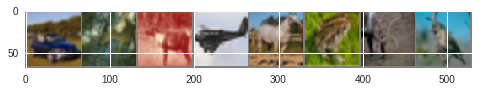

In [41]:
# visualize and understand the data
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images[:8]))
# print labels
print(' '.join('%5s' % set_classes[labels[j]] for j in range(8)))

In [42]:
def gaussian_noise_sampler(mu, sigma, device):
    """ Gaussian input to the generator"""
    return lambda m, n: torch.Tensor(np.random.normal(mu, sigma, (m, n))).to(device)


def uniform_noise_sampler(a, b, device):
    """ Uniform input to the generator of a m x n tensor"""
    return lambda m, n: (b - a) * torch.rand(m, n, 1, 1).to(device) + a
  
def plot_a_gen_sample(gen_sample):
    img = gen_sample.view(image_size, image_size)
    plt.imshow(img, cmap='Greys_r')  
    plt.show()

        
def one_hot(batch, depth):
    ones = torch.eye(depth).to(device)
    return ones.index_select(0, batch)     
    
def fake_target_sampler(device, n_classes):
    """ Generate fake targets """
    return lambda m: torch.floor(n_classes * torch.rand(m)).long().to(device)

# This will be our sampler for fake labels
target_sampler = fake_target_sampler(device, num_classes)

# We feed in the generator a noise input   
# Uniform sampler on [-1, 1]
g_noise_input_generator = uniform_noise_sampler(-1, 1, device)
# Input noise of size 100
dim_gen_input = 100 

fixed_noise = g_noise_input_generator(5 * 5, dim_gen_input)
fixed_labels = target_sampler(5 * 5)
fixed_labels = one_hot(fixed_labels, num_classes)
fixed_labels = fixed_labels.view(5 * 5, num_classes, 1, 1)
print('fixed_labels.shape =', fixed_labels.shape)

def show_result(model_G, dim_gen_input, num_epoch,
                show = False, save = False, path = 'result.png', isFix=False):
    
    with torch.no_grad():

      if isFix:
          test_images = model_G(fixed_noise, fixed_labels)
      else:            
          random_noise = g_noise_input_generator(5 * 5, dim_gen_input)
          random_labels = target_sampler(5 * 5)
          random_labels = one_hot(random_labels, num_classes)
          random_labels = random_labels.view(5 * 5, num_classes, 1, 1)
          test_images = model_G(random_noise, random_labels)

      size_figure_grid = 5
      fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
      for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
          ax[i, j].get_xaxis().set_visible(False)
          ax[i, j].get_yaxis().set_visible(False)

      for k in range(5*5):
          i = k // 5
          j = k % 5
          ax[i, j].cla()
          if train_MNIST:
            ax[i, j].imshow(test_images[k, :].cpu().data.view(image_size, image_size).numpy(), cmap='gray')
          else:
            ax[i, j].imshow((test_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)

      label = 'Epoch {0}'.format(num_epoch)
      fig.text(0.5, 0.04, label, ha='center')
      plt.savefig(path)

      if show:
          plt.show()
      else:
          plt.close()
        
    
def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(path)

    if show:
        plt.show()
    else:
        plt.close()   
       
  
print('ok')

fixed_labels.shape = torch.Size([25, 10, 1, 1])
ok


In [0]:
# Standard slope of the leak of LeakyReLU is 0.01, 0.2 recommended by DCGAN paper
# but 0.2 seems to work very badly on our 2d data sets
slope_lrelu = 0.2
# 'k' steps in the original GAN paper. Can put the discriminator on higher training freq than generator
d_steps = 1

if use_wasserstein_gan:
  d_steps = 5

g_steps = 1

n_epochs = 20

class Generator(nn.Module):
  
    def __init__(self, dim_input):
        super(Generator, self).__init__()
        # Latent code
        self.conv1_input = nn.ConvTranspose2d(dim_input, 512, 4, 1, 0, bias=False)
        self.bn1_input = nn.BatchNorm2d(512)
        # Labels
        self.conv1_labels = nn.ConvTranspose2d(num_classes, 512, 4, 1, 0, bias=False)
        self.bn1_labels = nn.BatchNorm2d(512)
        
        # state size. (1024) x 4 x 4
        self.conv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False)
        self.bn2 =nn.BatchNorm2d(512)
        # state size. (512) x 8 x 8
        self.conv3 = nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(256)
        # state size. (256) x 16 x 16
        self.conv4 = nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)
        # state size. (128) x 32 x 32
        self.conv5 = nn.ConvTranspose2d(128, n_channels, 4, 2, 1, bias=False)
        self.tanh = nn.Tanh()
        # state size. (n_channels) x 64 x 64
     

    def forward(self, z, labels):
        # Images
        x = F.relu(self.bn1_input(self.conv1_input(z)))
        # Labels
        y = F.relu(self.bn1_labels(self.conv1_labels(labels)))
        
        # Concatenate both together
        out = torch.cat([x,y], 1)
        
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.relu(self.bn3(self.conv3(out)))
        out = F.relu(self.bn4(self.conv4(out)))
        out = self.tanh(self.conv5(out))
        return out


dim_images = int(image_size ** 2)

model_G = Generator(dim_gen_input).to(device)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
         # input is (n_channels) x 64 x 64
        self.conv1_input = nn.Conv2d(n_channels, 64, 4, 2, 1, bias=False)
        self.bn1_input = nn.BatchNorm2d(64)
        self.conv1_labels = nn.Conv2d(num_classes, 64, 4, 2, 1, bias=False)
        self.bn1_labels = nn.BatchNorm2d(64)
        
        # state size. (128) x 32 x 32
        self.conv2 = nn.Conv2d(128, 256, 4, 2, 1, bias=False)
        self.bn2 =nn.BatchNorm2d(256)
        # state size. (256) x 16 x 16
        self.conv3 = nn.Conv2d(256, 512, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(512)
        # state size. (512) x 8 x 8
        self.conv4 = nn.Conv2d(512, 1024, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm2d(1024)
        # state size. (1024) x 4 x 4
        self.conv5 = nn.Conv2d(1024, 1, 4, 1, 0, bias=False)
        # state size. (n_channels) x 64 x 64
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputs, labels):
        # Images
        x = F.leaky_relu(self.bn1_input(self.conv1_input(inputs)), negative_slope=slope_lrelu, inplace=True)
        # Labels
        y = F.leaky_relu(self.bn1_labels(self.conv1_labels(labels)), negative_slope=slope_lrelu, inplace=True)
        # Concatenate both together
        out = torch.cat([x,y], 1)
        
        out = F.leaky_relu(self.bn2(self.conv2(out)), negative_slope=slope_lrelu, inplace=True)
        out = F.leaky_relu(self.bn3(self.conv3(out)), negative_slope=slope_lrelu, inplace=True)
        out = F.leaky_relu(self.bn4(self.conv4(out)), negative_slope=slope_lrelu, inplace=True)
     
        # Training a standard binary classifier with a
        # sigmoid output (--> using Binary Cross Entropy Loss
        return self.sigmoid(self.conv5(out))


# Single dimension for 'real' vs. 'fake'
# We can change this if we want to use gans that also classify
d_output_size = 1

model_D = Discriminator().to(device)


In [44]:
# Training
# Use same learning rates  for generator + discriminator
# Learning rates recommended by the DCGAN paper for Adam
learning_rate = 2e-4
# From https://github.com/soumith/ganhacks, use Adam Optimizer
d_optimizer = optim.Adam(model_D.parameters(), lr=learning_rate, betas=(0.5, 0.999))
g_optimizer = optim.Adam(model_G.parameters(), lr=learning_rate, betas=(0.5, 0.999))
# use binary cross entropy loss function
loss_fn = nn.BCELoss()

arr_gradient_D = []
arr_gradient_G = []
arr_means = []
arr_std_dev = []
# set to true or false to plot the mean and std_dev
plot_means_and_var = False

real_label = 1
fake_label = 0

# results save folder
if not os.path.isdir(added_path + 'Random_results'):
    os.mkdir(added_path + 'Random_results')
if not os.path.isdir(added_path + 'Fixed_results'):
    os.mkdir(added_path + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []

do_compute_norm = False


def reset_grad():
    model_G.zero_grad()
    model_D.zero_grad()

def train(model_G, model_D, epoch):

    model_D.train()
    model_G.train()
    
    D_losses = []
    G_losses = []
    
    time_now = time.clock()
    
    fill = torch.zeros([num_classes, num_classes, image_size, image_size])
    for i in range(num_classes):
        fill[i, i, :, :] = 1

    for batch_idx, (inputs, targets) in enumerate(train_loader):
      
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Weight clipping
        if use_wasserstein_gan:
            for p in model_D.parameters():
                p.data.clamp_(-0.01, 0.01)
                    
            # Housekeeping - reset gradient
            reset_grad()
          
        # (1) Update Discriminator : maximize log(D(x)) + log(1 - D(G(z)))
            
        # this is not necessarily equal to batch size !
        n_images = len(inputs)
            
        # Reset gradients
        model_D.zero_grad()

        # on real samples
        y_fill = fill[targets].to(device)
        d_real_decision = model_D(inputs, y_fill)

        # To compute BCE loss
        label = torch.full((n_images, 1, 1, 1), real_label, device=device)

        # on fake samples
        generated_class_labels = target_sampler(n_images)
        oh_gen_class_labels = one_hot(generated_class_labels, num_classes)
        oh_gen_class_labels = oh_gen_class_labels.view(n_images, num_classes, 1, 1)
        fill_gen_labels = fill[generated_class_labels].to(device)
        d_gen_input = g_noise_input_generator(n_images, dim_gen_input)
        
        d_fake_data = model_G(d_gen_input, oh_gen_class_labels).detach()  # detach to avoid training G on these labels
        d_fake_decision = model_D(d_fake_data, fill_gen_labels)
        # D(x) now wants to be as close as possible as fake label value
        f_label = torch.full((n_images, 1, 1, 1), fake_label, device=device)
          
            
        # Total loss
        if use_wasserstein_gan:
            d_real_loss = torch.mean(d_real_decision)
            d_fake_loss = torch.mean(d_fake_decision)
            d_train_loss = d_real_loss - d_fake_loss           
        else:
            d_real_loss = loss_fn(d_real_decision, label)
            d_fake_loss = loss_fn(d_fake_decision, f_label)
            d_train_loss = d_fake_loss + d_real_loss
            
                
        d_train_loss.backward() 
        d_optimizer.step()  # Only optimizes D's parameters; changes based on stored gradients from backward()
            
        D_losses.append(d_train_loss.item())
            
                             
        if do_compute_norm:
            # Compute the norm of gradient
            total_norm = 0
            for p in model_D.parameters():
                norm = p.grad.data.norm(2)
                total_norm += norm.item() ** 2
            total_norm = np.sqrt(total_norm)
            arr_gradient_D.append(total_norm)

            
        # Update every step generator if normal gan
        # update every n_step=5 if using wasserstein gan
        
        if d_steps == 1 or (batch_idx % d_steps == 0 and batch_idx > 0):
          for g_index in range(g_steps):
            
              # (2) Update G network: maximize log(D(G(z)))
              model_G.zero_grad()

              gen_input = g_noise_input_generator(n_images, dim_gen_input)
              
              generated_class_labels = target_sampler(n_images)
              oh_gen_class_labels = one_hot(generated_class_labels, num_classes)
              oh_gen_class_labels =  oh_gen_class_labels.view(n_images, num_classes, 1, 1)
              fill_gen_labels = fill[generated_class_labels].to(device)
              
              gen_output = model_G(gen_input, oh_gen_class_labels)
              d_fake_decision = model_D(gen_output, fill_gen_labels)

              # The generator tries to get D(G(z)) near 1
              label = torch.full((n_images, 1, 1, 1), real_label, device=device)
              g_loss = loss_fn(d_fake_decision,  label)

              g_loss.backward()
              g_optimizer.step()

              G_losses.append(g_loss.item())

              # Compute norm of gradient
              if do_compute_norm:
                total_norm = 0
                for p in model_G.parameters():
                    norm = p.grad.data.norm(2)
                    total_norm += norm.item() ** 2
                total_norm = np.sqrt(total_norm)
                arr_gradient_G.append(total_norm)
               
              

              updates = 10
              
              if batch_idx % updates == 0:            
                  # Store mean/std_dev            
                  if plot_means_and_var:
                      # Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.
                      np_gen_output = gen_output.detach().numpy()
                      mean = np.mean(np_gen_output)
                      std_dev = np.std(np_gen_output)
                      arr_means.append(mean)
                      arr_std_dev.append(std_dev)
                      print('mean = ', mean, ' std_dev = ', std_dev)

                  print('\rTrain Epoch: {} [{}/{} ({:.0f}%)] Time per epoch: {:.2f}s\t Gen_Loss: {:.4f}; D_Real_Loss: {:.4f}; D_Fake_Loss: {:.4f}'
                        .format(epoch, batch_idx * len(inputs), n_train_images,
                                100. * batch_idx / len(train_loader), n_train_images / (updates * batch_size) * (time.clock() - time_now), 
                                d_real_loss.item(), d_fake_loss.item(), g_loss.item()),
                        end='')        
                  time_now = time.clock()
                 
    return D_losses, G_losses

  
for ep in range(n_epochs):
    D_losses, G_losses = train(model_G, model_D, ep)
    
    p = added_path + 'Random_results/GAN_' + str(ep + 1) + '.png'
    fixed_p = added_path + 'Fixed_results/GAN_' + str(ep + 1) + '.png'
    show_result(model_G, dim_gen_input, (ep + 1), save=True, path=p, isFix=False)
    show_result(model_G, dim_gen_input, (ep + 1), save=True, path=fixed_p, isFix=True)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))

print('')
print("Training finish!... save training results")
torch.save(model_G.state_dict(), added_path + "generator_param.pkl")
torch.save(model_D.state_dict(), added_path + "discriminator_param.pkl")
with open(added_path + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path= added_path + 'GAN_train_hist.png')



Train Epoch: 19 [49920/50000 (100%)] Time per epoch: 609.26s	 Gen_Loss: 0.3578; D_Real_Loss: 0.1467; D_Fake_Loss: 1.0232
Training finish!... save training results


In [0]:
# Generate some animation..? (haven't used it)
images = []
for ep in range(n_epochs):
    img_name = added_path + 'Fixed_results/GAN_' + str(ep + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(added_path + 'generation_animation.gif', images, fps=5)

In [46]:

import torchvision.utils

# need to install this to save images via pytorch.. 
!pip install Pillow==4.0

In [0]:
# Save 10k images to a folder if you haven't already done so
# This will allow FID comparing
# Using Test set to compare !
def save_real_images_data_set(path):

  time_now = time.clock() 
  n_test_data = len(test_data)

  i = 0
  for batch_idx, (inputs, target) in enumerate(test_loader):

    n_inputs = len(inputs)

    for j in range(n_inputs):
        torchvision.utils.save_image(inputs[j, :], 
                                     path + 'img_' + str(i) + '.png', normalize = True)    
        i += 1

    print('\r Real_Images_Saved [{}/{} ({:.0f}%)] Time estimated left: {:.2f}s'
            .format(i, n_test_data, 100 * i / n_test_data, 
                    ((n_test_data - i) / batch_size) * (time.clock() - time_now)),   
            end='')
    time_now = time.clock()            
   
  
path_real = added_path + 'real_samples/'    

if not os.path.isdir(path_real):
    os.mkdir(path_real)
    save_real_images_data_set(path_real)
else:
    # don't compute twice !!
    print('Real Samples folder is already there !')
 


 Real_Images_Saved [10000/10000 (100%)] Time estimated left: 0.00s

In [9]:
# might need to reload model if we disconnected
model_G.load_state_dict(torch.load(added_path + 'generator_param.pkl'))
model_G.eval()

Generator(
  (conv1_input): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1_input): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_labels): ConvTranspose2d(10, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1_labels): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(128, 1, kernel_siz

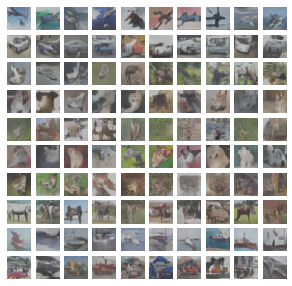

In [47]:
# Print a 10x10 grid of outputs of our c-gan
noise = g_noise_input_generator(10 * 10, dim_gen_input)
targets = torch.zeros((10, 10), device=device).long()
for i in range(1, 10):
    targets[i, :] = targets[i, :].new_full((10,), i, device=device).long()

targets = targets.view(10 * 10)
gen_labels = one_hot(targets, num_classes)
gen_labels =  gen_labels.view(10 * 10, num_classes, 1, 1)
gen_images = model_G(noise, gen_labels)


size_figure_grid = 10
fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

for k in range(10*10):
    i = k // 10
    j = k % 10
    ax[i, j].cla()
    if train_MNIST:
       ax[i, j].imshow(gen_images[k, :].cpu().data.view(image_size, image_size).numpy(), cmap='gray')
    else:
       ax[i, j].imshow((gen_images[k].cpu().data.numpy().transpose(1, 2, 0) + 1) / 2)

plt.show()

In [48]:
# Generate 10k samples
# by 100 batches of 100
import torchvision.utils

path_gen = added_path + 'gen_samples/'
if not os.path.isdir(path_gen):
    os.mkdir(path_gen)
    

time_now = time.clock() 
for i in range(100):
  noise = g_noise_input_generator(100, dim_gen_input)
  gen_labels = target_sampler(100)
  gen_labels = one_hot(gen_labels, num_classes)
  gen_labels =  gen_labels.view(100, num_classes, 1, 1)
  gen_images = model_G(noise, gen_labels)


  for j in range(100):
      torchvision.utils.save_image(gen_images[j, :], 
                        path_gen + 'img_' + str(i*100 + j) + '.png', normalize = True)    
      
  print('\r Gen_Images_Saved [{}/{} ({:.0f}%)] Time estimated left: {:.2f}s'
        .format((i + 1) * 100, 10000, (i + 1), (99 - i) * (time.clock() - time_now)),   
         end='')
  time_now = time.clock()
          

     
  
              
    

 Gen_Images_Saved [10000/10000 (100%)] Time estimated left: 0.00s